**Penn State Football Recruit Map (2014-2024)**

The notebook below is a simplified example of how to scrape several years of data and plot it on a map solely using python. It collects data from a college football recruiting website for the years 2014 through 2023 plotting each hometown. The output can be stylized just as you would any other webmap however since that wasn't the focal point here it's kept generic only changeing the baselayer and circle color.

Make sure the required libraries are installed

In [ ]:
!pip install --upgrade geopandas
!pip install --upgrade folium
!pip install contextily
!pip install matplotlib
!pip install mapclassify

Import the modules that will be utilized

In [1]:
import requests
import geopandas as gpd
from bs4 import BeautifulSoup
import matplotlib

Initialize functions to be used later on

In [2]:
def generate_uuid():
    num = 0
    while num < 2000:
        yield num
        num += 1

def init_dict():
    keys = ['name','hometown','ranking','class_year']
    rinfo = {key: [] for key in keys}
    return rinfo

Loop through the years you'd like to collect the data for while scraping it along the way. Requests will grab all available data and Beautiful Soup will target specific sections that'll be parsed and added to a dictionary

In [3]:
INITIAL_CLASS = 2014
LAST_CLASS = 2024

# run the generator function to collect a series of ids
g_obj = generate_uuid()

# initialize a dictionary to contain the recruits and their info
recruits = dict()

for yr in range(INITIAL_CLASS,LAST_CLASS):
    url = f'https://www.on3.com/college/penn-state-nittany-lions/football/{str(yr)}/commits/'
    response = requests.get(url)

    soup = BeautifulSoup(response.content, 'html.parser')

    ind_recruits = soup.find_all("div",{"class":"CommitListItem_playerWrapper__56t1h"})

    # loop through each individual's soup
    for r in range(len(ind_recruits)-1):
        # create a clean dictionary object
        rinfo = init_dict()

        # grab the next unique id
        uuid = next(g_obj)

        # don't include players who transferred out
        if "Transferred" in str(ind_recruits[r]):
            break

        # parse the soup of individual players
        name = str(ind_recruits[r])[str(ind_recruits[r]).find('alt="')+5:str(ind_recruits[r]).find(' Avatar')]
        hometown = str(ind_recruits[r])[str(ind_recruits[r]).find('(')+1:str(ind_recruits[r]).find(')')]

        # transfers don't have a ranking causing a value error as you can't cast none to float
        try:
            star = ind_recruits[r].find('span', {'class':'StarRating_overallRating__MTh52 StarRating_bolded__kr_6V StarRating_border__DffWl'})
            rank = str(star)[str(star).find('>')+1:str(star).rfind('<')]
            ranking = float(rank)
        except ValueError:
            ranking = None

        # assign values to dictionary keys - can be rolled up into the above section
        rinfo['name'] = name
        rinfo['hometown'] = hometown.replace('<!-- -->','')
        rinfo['ranking'] = ranking
        rinfo['class_year'] = yr

        # compile attributes into a dictionary with a unique id
        recruits[f'{uuid}'] = rinfo


Convert the dictionary of dictionaries to a GeoDataFrame (since we're using GeoPandas). It'll look funny as it comes in with the indexes flipped

In [4]:
gdf = gpd.GeoDataFrame(recruits)
gdf

,0,1,2,3,4,5,6,7,8,9,...,226,227,228,229,230,231,232,233,234,235
name,DeAndre Thompkins,Chris Godwin,Saeed Blacknall,Mike Gesicki,Michael O'Connor,Tarow Barney,Koa Farmer,Johnathan Thomas,Troy Reeder,Troy Apke,...,Carmelo Taylor,Joseph Mupoyi,London Montgomery,Mason Robinson,Tyriq Blanding,Cameron Wallace,Malik McClain,Storm Duck,Dante Cephas,Alex Felkins
hometown,"Swansboro, NC","Middletown, DE","Englishtown, NJ","Manahawkin, NJ","Bradenton, FL","Senatobia, MS","Sherman Oaks, CA","Danvers, MA","Wilmington, DE","Pittsburgh, PA",...,"Roanoke, VA","Oakdale, CT","Scranton, PA","Owings Mills, MD","Middle Village, NY","Mount Vernon, GA","Bradenton, FL","Boiling Springs, SC","Pittsburgh, PA","Tulsa, OK"
ranking,92.72,92.52,92.43,91.44,91.4,91.06,90.15,89.0,88.9,88.37,...,90.42,89.5,88.36,87.55,86.28,85.55,None,None,90.0,None
class_year,2014,2014,2014,2014,2014,2014,2014,2014,2014,2014,...,2023,2023,2023,2023,2023,2023,2023,2023,2023,2023


In order to correct that, transpose it (.T) to get the uuid as the first column index. Take another look

In [5]:
gdf = gdf.T
gdf

,name,hometown,ranking,class_year
0,DeAndre Thompkins,"Swansboro, NC",92.72,2014
1,Chris Godwin,"Middletown, DE",92.52,2014
2,Saeed Blacknall,"Englishtown, NJ",92.43,2014
3,Mike Gesicki,"Manahawkin, NJ",91.44,2014
4,Michael O'Connor,"Bradenton, FL",91.4,2014
...,...,...,...,...
231,Cameron Wallace,"Mount Vernon, GA",85.55,2023
232,Malik McClain,"Bradenton, FL",None,2023
233,Storm Duck,"Boiling Springs, SC",None,2023
234,Dante Cephas,"Pittsburgh, PA",90.0,2023


Geocode those results

In [6]:
geocodes = gpd.tools.geocode(gdf['hometown'],provider='nominatim',user_agent='cmaps_ex',timeout=1000)

Attach the newly acquired spatial data to your DataFrame

In [7]:
gdf = gpd.GeoDataFrame(gdf.join(geocodes))

Check out the GeoDataFrame and notice that you now have spatial data associated with each record

In [8]:
gdf

,name,hometown,ranking,class_year,geometry,address
0,DeAndre Thompkins,"Swansboro, NC",92.72,2014,POINT (-77.12322 34.68967),"Swansboro, Onslow County, North Carolina, Unit..."
1,Chris Godwin,"Middletown, DE",92.52,2014,POINT (-71.29144 41.54566),"Middletown, Newport County, Rhode Island, 0284..."
2,Saeed Blacknall,"Englishtown, NJ",92.43,2014,POINT (-74.35820 40.29733),"Englishtown, Monmouth County, New Jersey, Unit..."
3,Mike Gesicki,"Manahawkin, NJ",91.44,2014,POINT (-74.24881 39.69070),"Manahawkin, Stafford Township, Ocean County, N..."
4,Michael O'Connor,"Bradenton, FL",91.4,2014,POINT (-82.57482 27.49893),"Bradenton, Manatee County, Florida, United States"
...,...,...,...,...,...,...
231,Cameron Wallace,"Mount Vernon, GA",85.55,2023,POINT (-82.59458 32.17851),"Mount Vernon, Montgomery County, Georgia, 3044..."
232,Malik McClain,"Bradenton, FL",None,2023,POINT (-82.57482 27.49893),"Bradenton, Manatee County, Florida, United States"
233,Storm Duck,"Boiling Springs, SC",None,2023,POINT (-81.97882 35.04136),"Boiling Springs, Spartanburg County, South Car..."
234,Dante Cephas,"Pittsburgh, PA",90.0,2023,POINT (-79.99009 40.44169),"Pittsburgh, Allegheny County, Pennsylvania, Un..."


Utilize Folium to see the results on an interactive map directly in the notebook

In [9]:
gdf.explore(
    min_lat=25,min_lon=-125,max_lat=50,max_lon=-66.5,
    max_bounds=True,
    zoom_start=4,
    tiles = "CartoDB DarkMatterNoLabels",
    style_kwds = dict(color="cyan", #stroke color
                      weight='1', #stoke width
                         ),
    )

See if there's a trend in anticipated class strength using the rankings. Group by the year and take the mean in this case 

In [10]:
strength = gdf.groupby(['class_year'])['ranking'].mean()

Plot it using GeoPandas Matplotlib extension

<AxesSubplot:xlabel='class_year'>

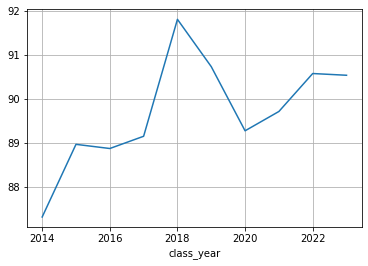

In [11]:
strength.plot(grid=True)